In [14]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
!pip install pmdarima
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
#import tensorflow
#import keras
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import json
import re
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

# Tesla

In [8]:
# reload from pickle checkpoint
with open('tsla_combined_1.pkl', 'rb') as f:
    data = pickle.load(f)
data

,avg_price,compound_sentiment,positive_sentiment,negative_sentiment,neutral_sentiment,tweet_count,trade_volume
0,,,,,,,
2020-05-11 05:01:00,819.42000,0.510600,0.102000,0.000000,0.898000,1.0,0.0
2020-05-11 05:02:00,819.42000,0.421500,0.219000,0.000000,0.781000,1.0,0.0
2020-05-11 05:03:00,819.42000,0.421500,0.219000,0.000000,0.781000,0.0,0.0
2020-05-11 05:04:00,819.42000,0.843600,0.348000,0.000000,0.652000,1.0,0.0
2020-05-11 05:05:00,819.42000,-0.125000,0.034500,0.063000,0.902500,2.0,0.0
...,...,...,...,...,...,...,...
2020-05-15 15:56:00,800.55000,0.122817,0.089333,0.034333,0.876333,6.0,25768.0
2020-05-15 15:57:00,800.17255,0.178267,0.065000,0.000000,0.935000,3.0,35831.0
2020-05-15 15:58:00,799.68000,-0.324300,0.000000,0.162500,0.837500,2.0,33430.0


/Users/lucas/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  """Entry point for launching an IPython kernel.


<Figure size 432x288 with 0 Axes>

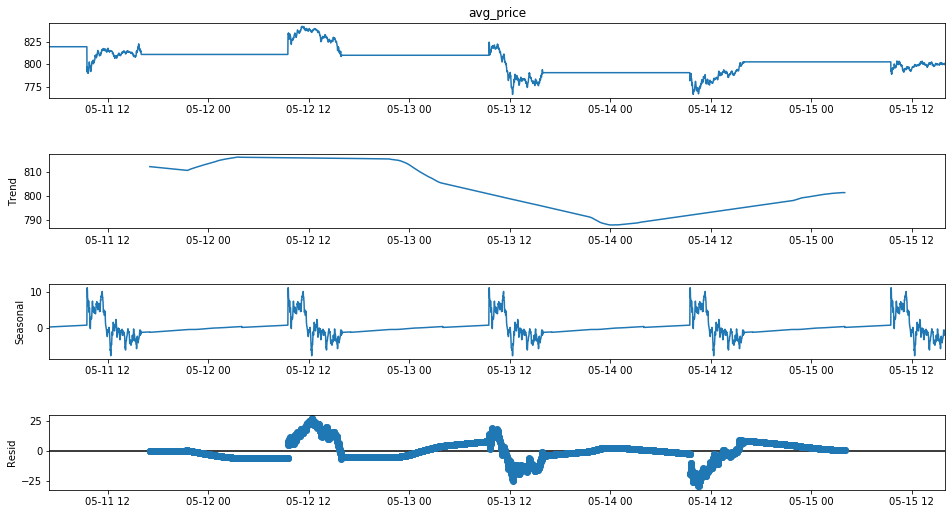

In [9]:
decomposition = seasonal_decompose(data['avg_price'], freq=24*60 )
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8)

In [10]:
from statsmodels.tsa.stattools import adfuller

#create a function that will help us to quickly 
def test_stationarity(timeseries, window):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)



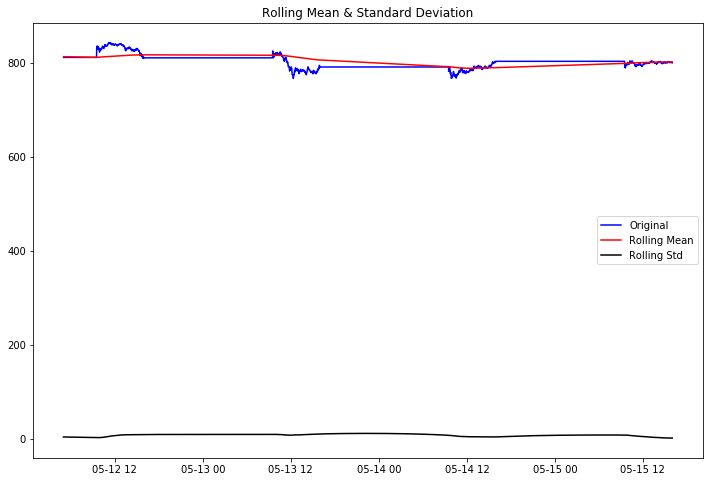

Results of Dickey-Fuller Test:
Test Statistic                   -2.436426
p-value                           0.131718
#Lags Used                       25.000000
Number of Observations Used    6394.000000
Critical Value (1%)              -3.431373
Critical Value (5%)              -2.861992
Critical Value (10%)             -2.567011
dtype: float64


In [11]:
#test the stationarity of the untransformed dataset
test_stationarity(data['avg_price'], 24*60)

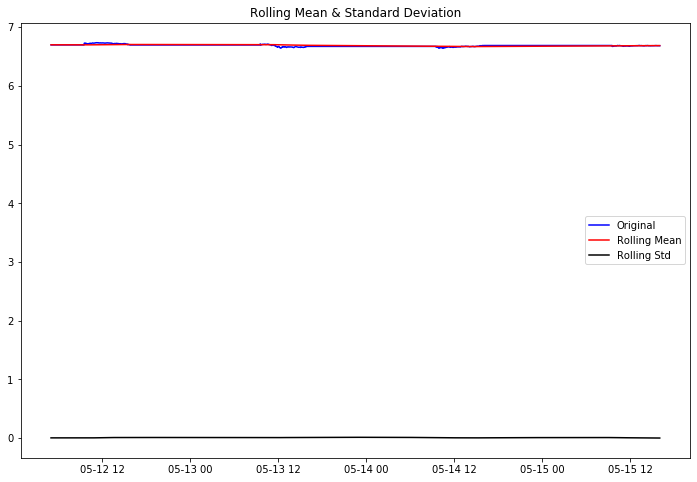

Results of Dickey-Fuller Test:
Test Statistic                   -2.440014
p-value                           0.130760
#Lags Used                       25.000000
Number of Observations Used    6394.000000
Critical Value (1%)              -3.431373
Critical Value (5%)              -2.861992
Critical Value (10%)             -2.567011
dtype: float64


In [12]:
data['log_price'] = data['avg_price'].apply(lambda x: np.log(x))  
test_stationarity(data['log_price'], 24*60)

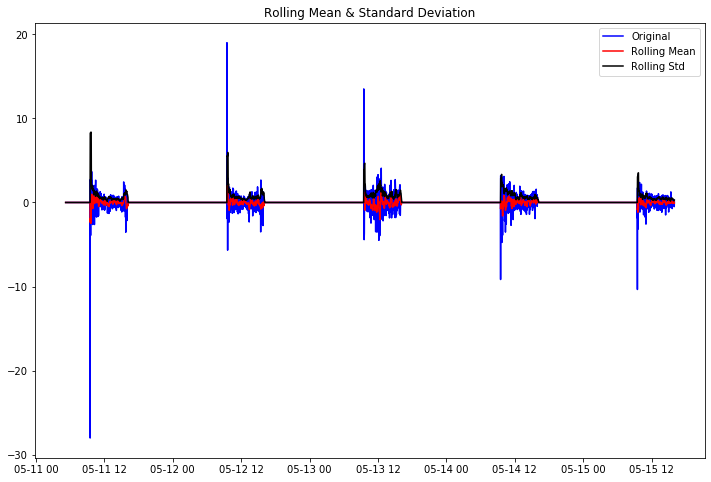

Results of Dickey-Fuller Test:
Test Statistic                -1.688374e+01
p-value                        1.058010e-29
#Lags Used                     2.400000e+01
Number of Observations Used    6.394000e+03
Critical Value (1%)           -3.431373e+00
Critical Value (5%)           -2.861992e+00
Critical Value (10%)          -2.567011e+00
dtype: float64


In [13]:
data['price_first_difference'] = data['avg_price'] - data['avg_price'].shift(1)  
test_stationarity(data['price_first_difference'].dropna(inplace=False),12)

In [3]:
lagged = data['avg_price'].shift(1)
k = lagged.fillna(method='bfill')

In [4]:
lagged_df = pd.concat([data['avg_price'], k], axis=1, keys=['avg_price', 'lagged_price'])
lagged_df

,avg_price,lagged_price
0,,
2020-05-11 05:01:00,819.42000,819.42000
2020-05-11 05:02:00,819.42000,819.42000
2020-05-11 05:03:00,819.42000,819.42000
2020-05-11 05:04:00,819.42000,819.42000
2020-05-11 05:05:00,819.42000,819.42000
...,...,...
2020-05-15 15:56:00,800.55000,800.85500
2020-05-15 15:57:00,800.17255,800.55000
2020-05-15 15:58:00,799.68000,800.17255


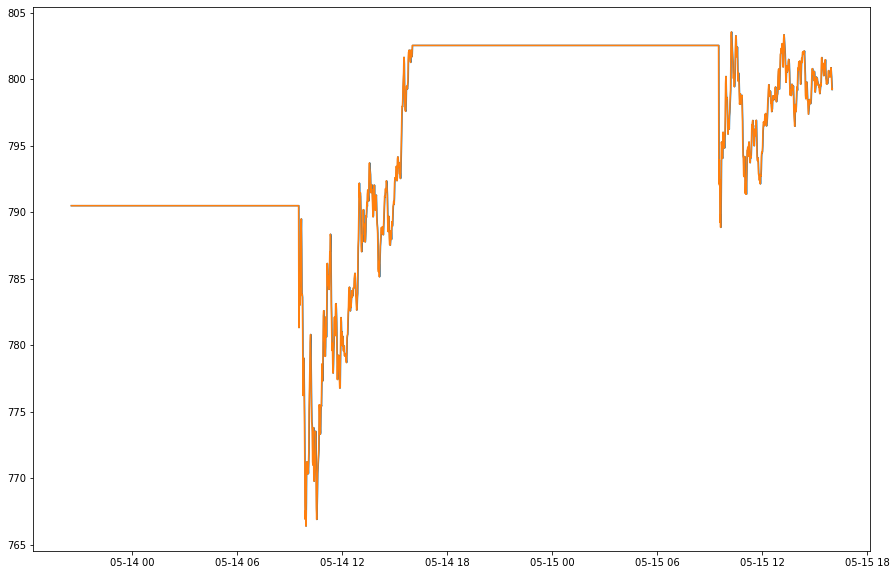

In [5]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], lagged_df['lagged_price'][-2610:])
plt.plot(data.index[-2610:], lagged_df['avg_price'][-2610:])

In [6]:
def calc_rmse(y_test, y_pred):
    return (sum([(y_test[i] - y_pred[i])**2 for i in range(len(y_test))])/len(y_test))**(1/2)


def calc_mae(y_test, y_pred):
    return (sum([abs(y_test[i] - y_pred[i]) for i in range(len(y_test))])/len(y_test))

rmse = calc_rmse(lagged_df['avg_price'][-2610:], lagged_df['lagged_price'][-2610:])
rmse

0.538490130650017

In [7]:
rmse/lagged_df['avg_price'][-2610:].std()

0.07269626323804362

In [8]:
data['avg_price']

0
2020-05-11 05:01:00    819.42000
2020-05-11 05:02:00    819.42000
2020-05-11 05:03:00    819.42000
2020-05-11 05:04:00    819.42000
2020-05-11 05:05:00    819.42000
                         ...    
2020-05-15 15:56:00    800.55000
2020-05-15 15:57:00    800.17255
2020-05-15 15:58:00    799.68000
2020-05-15 15:59:00    799.20750
2020-05-15 16:00:00    799.26945
Name: avg_price, Length: 6420, dtype: float64

In [9]:
k = data[['avg_price']]
k.values

array([[819.42   ],
       [819.42   ],
       [819.42   ],
       ...,
       [799.68   ],
       [799.2075 ],
       [799.26945]])

In [10]:
# load dataset
values = k.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 270
n_features = 1
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, n_hours, 1)
print(reframed.head())

     var1(t-270)  var1(t-269)  var1(t-268)  var1(t-267)  var1(t-266)  \
270     0.701208     0.701208     0.701208     0.701208     0.701208   
271     0.701208     0.701208     0.701208     0.701208     0.701208   
272     0.701208     0.701208     0.701208     0.701208     0.701208   
273     0.701208     0.701208     0.701208     0.701208     0.701208   
274     0.701208     0.701208     0.701208     0.701208     0.701208   

     var1(t-265)  var1(t-264)  var1(t-263)  var1(t-262)  var1(t-261)  \
270     0.701208     0.701208     0.701208     0.701208     0.701208   
271     0.701208     0.701208     0.701208     0.701208     0.701208   
272     0.701208     0.701208     0.701208     0.701208     0.701208   
273     0.701208     0.701208     0.701208     0.701208     0.701208   
274     0.701208     0.701208     0.701208     0.701208     0.701208   

     var1(t-260)  var1(t-259)  var1(t-258)  var1(t-257)  var1(t-256)  \
270     0.701208     0.701208     0.701208     0.701208     0.

In [11]:
# split into train and test sets
values = reframed.values
n_train_hours = len(data.loc[:'2020-05-13 16:00:00'])
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3540, 270) 3540 (3540,)
(3540, 270, 1) (3540,) (2610, 270, 1) (2610,)


Train on 3540 samples, validate on 2610 samples
Epoch 1/20
3540/3540 - 80s - loss: 0.0207 - val_loss: 0.0058
Epoch 2/20
3540/3540 - 78s - loss: 0.0037 - val_loss: 0.0049
Epoch 3/20
3540/3540 - 78s - loss: 0.0031 - val_loss: 0.0041
Epoch 4/20
3540/3540 - 78s - loss: 0.0026 - val_loss: 0.0034
Epoch 5/20
3540/3540 - 78s - loss: 0.0022 - val_loss: 0.0029
Epoch 6/20
3540/3540 - 77s - loss: 0.0018 - val_loss: 0.0024
Epoch 7/20
3540/3540 - 78s - loss: 0.0016 - val_loss: 0.0020
Epoch 8/20
3540/3540 - 78s - loss: 0.0014 - val_loss: 0.0017
Epoch 9/20
3540/3540 - 77s - loss: 0.0012 - val_loss: 0.0015
Epoch 10/20
3540/3540 - 78s - loss: 0.0011 - val_loss: 0.0013
Epoch 11/20
3540/3540 - 78s - loss: 9.6989e-04 - val_loss: 0.0011
Epoch 12/20
3540/3540 - 78s - loss: 8.9224e-04 - val_loss: 9.8652e-04
Epoch 13/20
3540/3540 - 77s - loss: 8.3255e-04 - val_loss: 8.9148e-04
Epoch 14/20
3540/3540 - 77s - loss: 7.8691e-04 - val_loss: 8.2149e-04
Epoch 15/20
3540/3540 - 77s - loss: 7.5233e-04 - val_loss: 7.7137

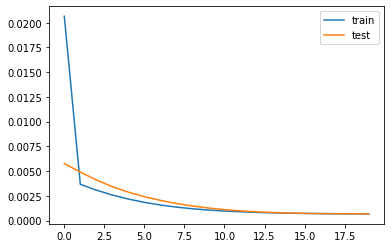

In [12]:
# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [13]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test MAE: %.3f' % mae)

Test RMSE: 1.985
Test MAE: 1.782


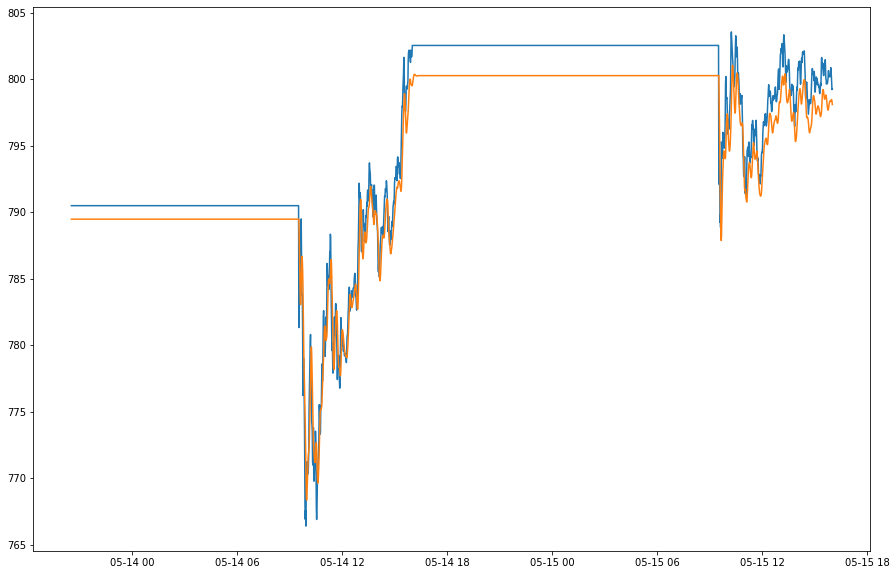

In [15]:
fig, ax = plt.subplots(1, figsize=(15,10))
plt.plot(data.index[-2610:], inv_y)
plt.plot(data.index[-2610:], inv_yhat)

# Amazon